<a href="https://colab.research.google.com/github/theoVasilas/Diplomatic_incident/blob/Centralized-training/training_Diabites.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installations

In [1]:
from collections import OrderedDict, Counter
from typing import Dict, List, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset, Subset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on {device}")

Training on cpu


# Dataloader


In [2]:
# Load the Pima Indians Diabetes dataset
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv'
column_names = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
                'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']

df = pd.read_csv(url, names=column_names)

# Split the data into features and target variable
X = df.drop(columns=['Outcome'])
y = df['Outcome']

# Normalize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.long)

# Split the data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_tensor, y_tensor, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Create data loaders
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

trainloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
testloader = DataLoader(test_dataset, batch_size=32, shuffle=False)


print(f"Training samples: {len(trainloader.dataset)}")
print(f"Validation samples: {len(valloader.dataset)}")
print(f"Test samples: {len(testloader.dataset)}")


Training samples: 537
Validation samples: 115
Test samples: 116


Basic Statistics:
       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.760232    0.476951  
min      0.000000

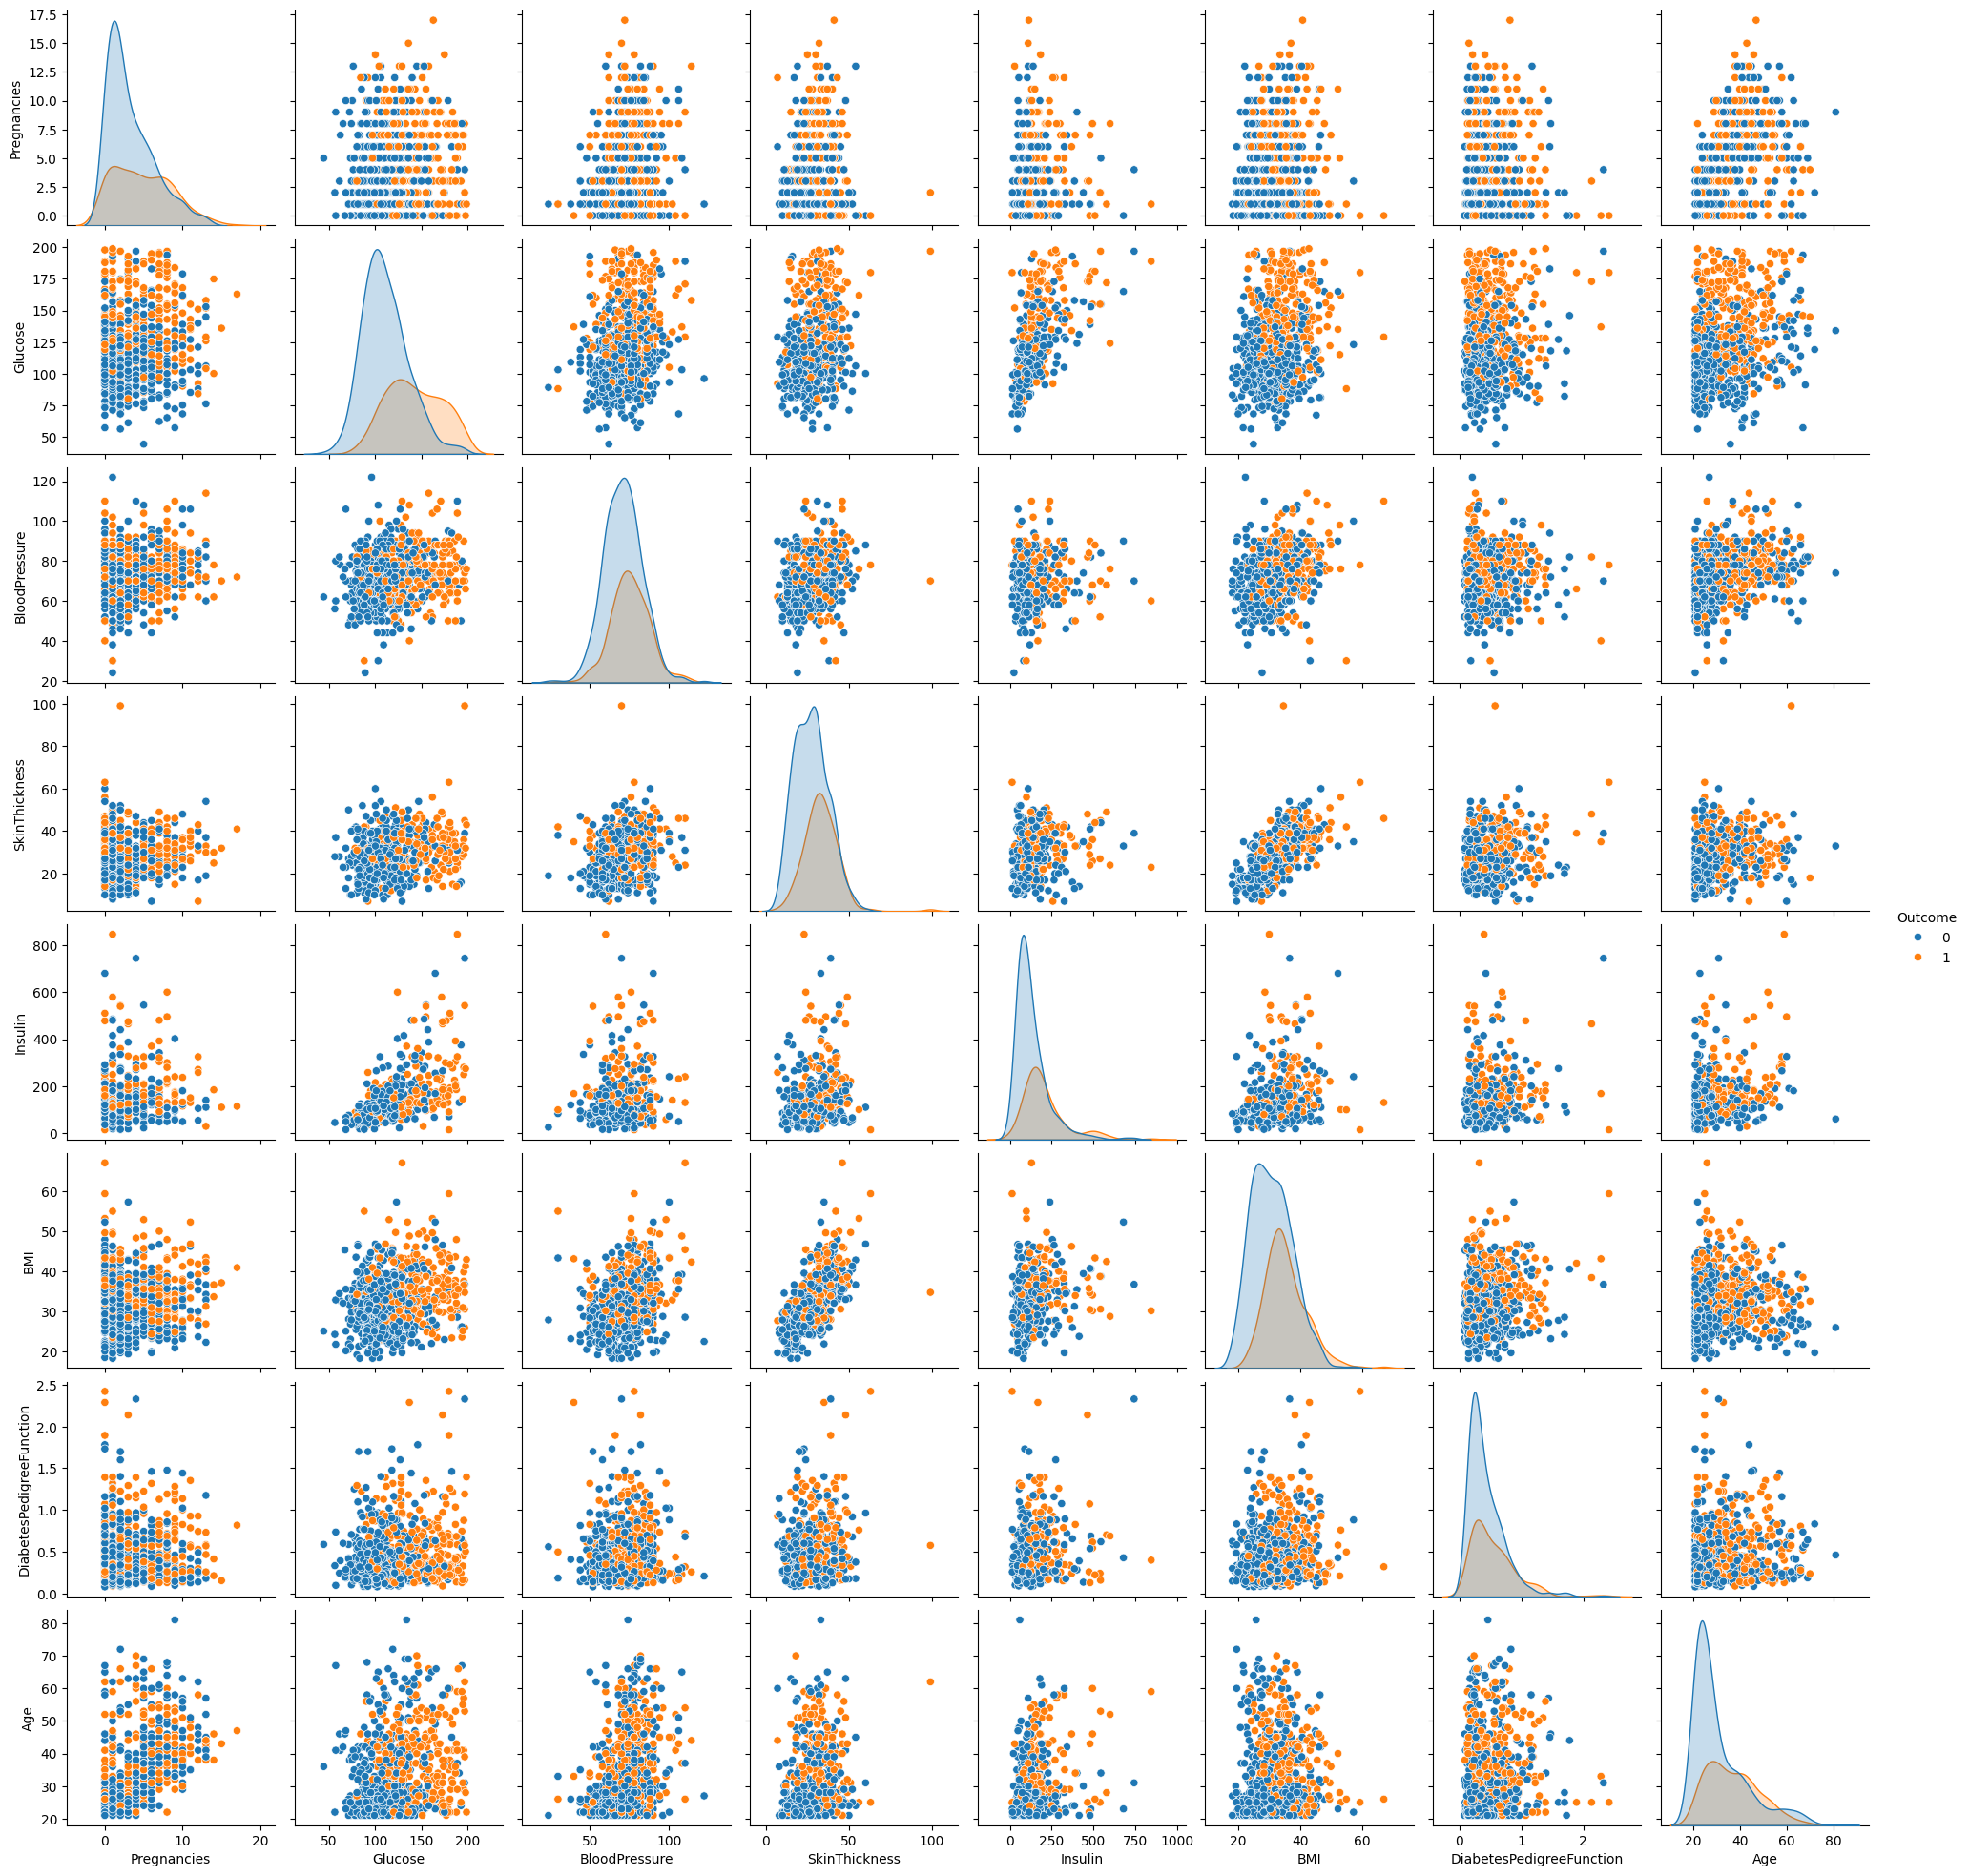

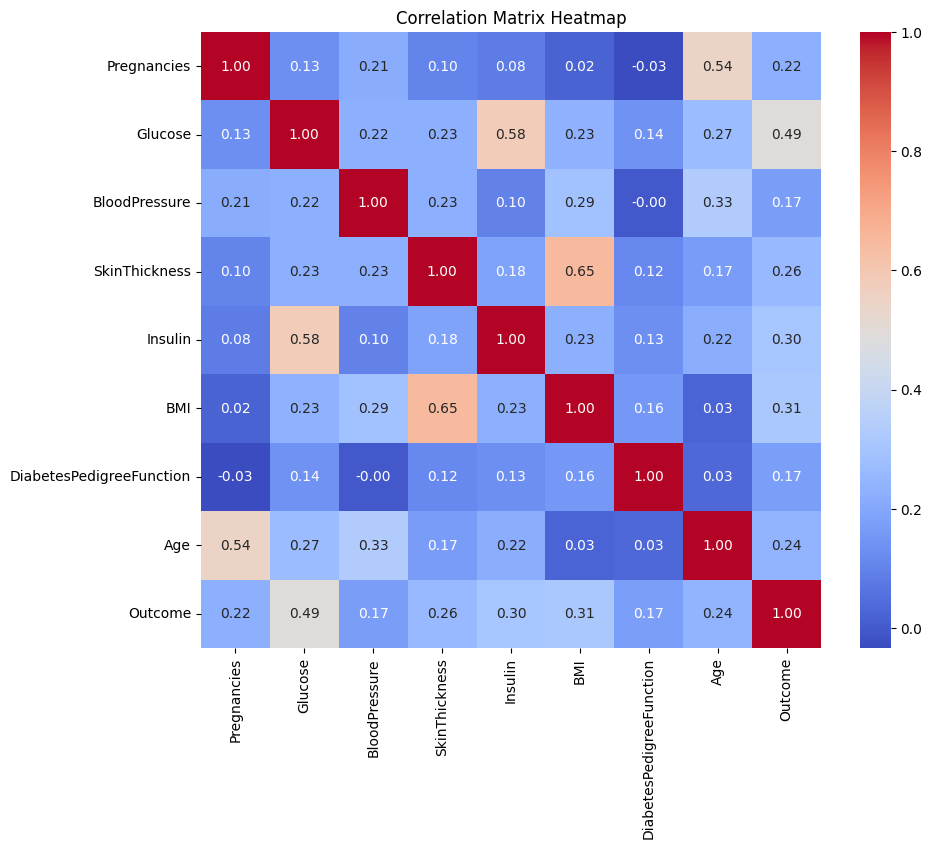

In [3]:
import pandas as pd
import numpy as np

# Load dataset
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv'
column_names = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
                'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
df = pd.read_csv(url, names=column_names)

# Basic statistics
print("Basic Statistics:")
print(df.describe())

# Count missing or zero values (where zeros are invalid)
zero_columns = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
zero_counts = (df[zero_columns] == 0).sum()
print("\nCount of Zero Values:")
print(zero_counts)

# Replace zero values with NaN for further analysis (optional)
df[zero_columns] = df[zero_columns].replace(0, np.nan)

# Check for missing values after replacing zeros
print("\nMissing Values:")
print(df.isnull().sum())

# Class distribution
print("\nClass Distribution:")
print(df['Outcome'].value_counts())

# Correlation matrix
print("\nCorrelation Matrix:")
print(df.corr())

# Visualizations (optional)
import matplotlib.pyplot as plt
import seaborn as sns

# Pairplot
sns.pairplot(df, hue="Outcome")
plt.show()

# Heatmap for correlation
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix Heatmap')
plt.show()


# train loop


In [4]:
from tqdm import tqdm  # For progress bars

def train(
    net,
    trainloader,
    valloader,
    optimizer,
    step_size,
    epochs: int,
    accuracy_threshold=0.90,  # Early stopping threshold for validation accuracy
    verbose=False
):

    criterion = torch.nn.BCEWithLogitsLoss()  # Binary classification loss
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.5)  # Optional scheduler
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    # Training loop
    for epoch in range(epochs):
        lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}/{epochs} - Learning Rate: {lr}")

        net.train()
        train_loss, train_correct, train_total = 0.0, 0, 0

        # Training Phase
        for features, labels in tqdm(trainloader, desc=f"Epoch {epoch+1} Training"):
            try:
                features, labels = features.to(device), labels.float().to(device)  # Labels must be float for BCE
                optimizer.zero_grad()

                outputs = net(features).squeeze(1)  # Squeeze for compatibility with BCEWithLogitsLoss
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                # Metrics
                train_loss += loss.item()
                train_total += labels.size(0)
                predictions = torch.sigmoid(outputs)  # Apply sigmoid for binary classification
                predictions = (predictions > 0.5).float()  # Convert to 0 or 1
                train_correct += (predictions == labels).sum().item()
            except Exception as e:
                print(f"Error in training step: {e}")

        # Compute averages
        train_loss /= len(trainloader)
        train_acc = train_correct / train_total

        # Validation Phase
        net.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for features, labels in tqdm(valloader, desc=f"Epoch {epoch+1} Validation"):
                try:
                    features, labels = features.to(device), labels.float().to(device)  # Labels must be float for BCE

                    outputs = net(features).squeeze(1)  # Squeeze for compatibility with BCEWithLogitsLoss
                    loss = criterion(outputs, labels)

                    # Metrics
                    val_loss += loss.item()
                    val_total += labels.size(0)
                    predictions = torch.sigmoid(outputs)  # Apply sigmoid for binary classification
                    predictions = (predictions > 0.5).float()  # Convert to 0 or 1
                    val_correct += (predictions == labels).sum().item()
                except Exception as e:
                    print(f"Error in validation step: {e}")

        # Compute averages
        val_loss /= len(valloader)
        val_acc = val_correct / val_total

        # Step the scheduler
        scheduler.step()

        # Save metrics to history
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        # Verbose logging
        if verbose:
            print(
                f"Epoch {epoch+1}/{epochs} "
                f"- Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} "
                f"- Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}"
            )

        # Early stopping based on validation accuracy
        if val_acc >= accuracy_threshold:
            print(f"Early stopping: Validation accuracy reached {accuracy_threshold*100}%")
            break

    return history


# test loop

In [5]:
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, auc
import numpy as np
from sklearn import metrics

def test(net, testloader, threshold = 0.5 ):
    criterion = torch.nn.BCEWithLogitsLoss()  # For binary classification
    net.eval()  # Set the model to evaluation mode
    test_loss, test_correct, test_total = 0.0, 0, 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():  # No gradient calculation during testing
        for features, labels in testloader:  # Use testloader
            try:
                features, labels = features.to(device), labels.float().to(device)  # Labels must be float for BCE

                outputs = net(features).squeeze(1)  # Squeeze for compatibility with BCEWithLogitsLoss
                loss = criterion(outputs, labels)

                # Metrics
                test_loss += loss.item()
                test_total += labels.size(0)
                all_labels.extend(labels.cpu().numpy())  # Collect the true labels
                all_predictions.extend(torch.sigmoid(outputs).cpu().numpy())  # Collect predicted probabilities

                # Binary predictions
                predictions = (torch.sigmoid(outputs) > threshold).float()  # Convert to 0 or 1
                test_correct += (predictions == labels).sum().item()

            except Exception as e:
                print(f"Error in testing step: {e}")

    # Compute averages
    test_loss /= len(testloader)
    test_acc = test_correct / test_total

    # Compute AUC
    auc = roc_auc_score(all_labels, all_predictions)  # Compute AUC using sklearn

    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(all_labels, all_predictions)
    roc_auc = metrics.auc(fpr, tpr)

    # Plot the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.4f}')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, (np.array(all_predictions) > 0.5).astype(int))  # Binary classification

    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}, AUC: {auc:.4f}")
    print(f"Confusion Matrix:\n{cm}")

    return test_loss, test_acc, auc, cm


# Model 1

In [28]:
import torch.nn.init as init

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(8, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # Logit output
        return x

    def reset_parameters(self):
      for layer in self.children():
          if isinstance(layer, nn.Linear):
              init.xavier_uniform_(layer.weight)  # Using Xavier initialization for weights
              init.zeros_(layer.bias)


In [29]:
model = Net()
num_parameters = sum(value.numel() for value in model.state_dict().values())
print(f"{num_parameters = }")

num_parameters = 2689


## run

Epoch 1/50 - Learning Rate: 0.01


Epoch 1 Validation: 100%|██████████| 4/4 [00:00<00:00, 376.34it/s]


Epoch 1/50 - Train Loss: 0.6397, Train Acc: 0.6238 - Val Loss: 0.5816, Val Acc: 0.6522
Epoch 2/50 - Learning Rate: 0.01


Epoch 2 Validation: 100%|██████████| 4/4 [00:00<00:00, 362.58it/s]


Epoch 2/50 - Train Loss: 0.5300, Train Acc: 0.7318 - Val Loss: 0.5258, Val Acc: 0.7304
Epoch 3/50 - Learning Rate: 0.01


Epoch 3 Validation: 100%|██████████| 4/4 [00:00<00:00, 230.83it/s]


Epoch 3/50 - Train Loss: 0.4811, Train Acc: 0.7784 - Val Loss: 0.5054, Val Acc: 0.7130
Epoch 4/50 - Learning Rate: 0.01


Epoch 4 Validation: 100%|██████████| 4/4 [00:00<00:00, 506.65it/s]


Epoch 4/50 - Train Loss: 0.4610, Train Acc: 0.7784 - Val Loss: 0.4977, Val Acc: 0.7304
Epoch 5/50 - Learning Rate: 0.01


Epoch 5 Validation: 100%|██████████| 4/4 [00:00<00:00, 159.44it/s]


Epoch 5/50 - Train Loss: 0.4456, Train Acc: 0.7821 - Val Loss: 0.5027, Val Acc: 0.7217
Epoch 6/50 - Learning Rate: 0.01


Epoch 6 Validation: 100%|██████████| 4/4 [00:00<00:00, 203.01it/s]


Epoch 6/50 - Train Loss: 0.4395, Train Acc: 0.7877 - Val Loss: 0.4999, Val Acc: 0.7391
Epoch 7/50 - Learning Rate: 0.01


Epoch 7 Validation: 100%|██████████| 4/4 [00:00<00:00, 684.67it/s]


Epoch 7/50 - Train Loss: 0.4310, Train Acc: 0.7952 - Val Loss: 0.4965, Val Acc: 0.7391
Epoch 8/50 - Learning Rate: 0.01


Epoch 8 Validation: 100%|██████████| 4/4 [00:00<00:00, 746.85it/s]


Epoch 8/50 - Train Loss: 0.4270, Train Acc: 0.7914 - Val Loss: 0.4984, Val Acc: 0.7391
Epoch 9/50 - Learning Rate: 0.01


Epoch 9 Validation: 100%|██████████| 4/4 [00:00<00:00, 576.34it/s]


Epoch 9/50 - Train Loss: 0.4220, Train Acc: 0.7970 - Val Loss: 0.4973, Val Acc: 0.7478
Epoch 10/50 - Learning Rate: 0.01


Epoch 10 Validation: 100%|██████████| 4/4 [00:00<00:00, 800.33it/s]


Epoch 10/50 - Train Loss: 0.4187, Train Acc: 0.7914 - Val Loss: 0.4984, Val Acc: 0.7391
Epoch 11/50 - Learning Rate: 0.01


Epoch 11 Validation: 100%|██████████| 4/4 [00:00<00:00, 742.35it/s]


Epoch 11/50 - Train Loss: 0.4158, Train Acc: 0.8007 - Val Loss: 0.4927, Val Acc: 0.7391
Epoch 12/50 - Learning Rate: 0.01


Epoch 12 Validation: 100%|██████████| 4/4 [00:00<00:00, 698.06it/s]


Epoch 12/50 - Train Loss: 0.4103, Train Acc: 0.8007 - Val Loss: 0.4963, Val Acc: 0.7391
Epoch 13/50 - Learning Rate: 0.01


Epoch 13 Validation: 100%|██████████| 4/4 [00:00<00:00, 696.01it/s]


Epoch 13/50 - Train Loss: 0.4036, Train Acc: 0.8045 - Val Loss: 0.5013, Val Acc: 0.7304
Epoch 14/50 - Learning Rate: 0.01


Epoch 14 Validation: 100%|██████████| 4/4 [00:00<00:00, 600.19it/s]


Epoch 14/50 - Train Loss: 0.4009, Train Acc: 0.7989 - Val Loss: 0.4962, Val Acc: 0.7391
Epoch 15/50 - Learning Rate: 0.01


Epoch 15 Validation: 100%|██████████| 4/4 [00:00<00:00, 740.88it/s]


Epoch 15/50 - Train Loss: 0.3993, Train Acc: 0.8119 - Val Loss: 0.4947, Val Acc: 0.7391
Epoch 16/50 - Learning Rate: 0.01


Epoch 16 Validation: 100%|██████████| 4/4 [00:00<00:00, 555.22it/s]


Epoch 16/50 - Train Loss: 0.3956, Train Acc: 0.8138 - Val Loss: 0.5032, Val Acc: 0.7304
Epoch 17/50 - Learning Rate: 0.01


Epoch 17 Validation: 100%|██████████| 4/4 [00:00<00:00, 599.53it/s]


Epoch 17/50 - Train Loss: 0.3920, Train Acc: 0.8082 - Val Loss: 0.4988, Val Acc: 0.7391
Epoch 18/50 - Learning Rate: 0.01


Epoch 18 Validation: 100%|██████████| 4/4 [00:00<00:00, 587.56it/s]


Epoch 18/50 - Train Loss: 0.3893, Train Acc: 0.8156 - Val Loss: 0.5002, Val Acc: 0.7391
Epoch 19/50 - Learning Rate: 0.01


Epoch 19 Validation: 100%|██████████| 4/4 [00:00<00:00, 617.67it/s]


Epoch 19/50 - Train Loss: 0.3873, Train Acc: 0.8138 - Val Loss: 0.5005, Val Acc: 0.7391
Epoch 20/50 - Learning Rate: 0.01


Epoch 20 Validation: 100%|██████████| 4/4 [00:00<00:00, 693.70it/s]


Epoch 20/50 - Train Loss: 0.3817, Train Acc: 0.8119 - Val Loss: 0.4962, Val Acc: 0.7391
Epoch 21/50 - Learning Rate: 0.005


Epoch 21 Validation: 100%|██████████| 4/4 [00:00<00:00, 666.32it/s]


Epoch 21/50 - Train Loss: 0.3825, Train Acc: 0.8194 - Val Loss: 0.4989, Val Acc: 0.7391
Epoch 22/50 - Learning Rate: 0.005


Epoch 22 Validation: 100%|██████████| 4/4 [00:00<00:00, 414.73it/s]


Epoch 22/50 - Train Loss: 0.3784, Train Acc: 0.8194 - Val Loss: 0.4980, Val Acc: 0.7391
Epoch 23/50 - Learning Rate: 0.005


Epoch 23 Validation: 100%|██████████| 4/4 [00:00<00:00, 728.81it/s]


Epoch 23/50 - Train Loss: 0.3777, Train Acc: 0.8194 - Val Loss: 0.4993, Val Acc: 0.7391
Epoch 24/50 - Learning Rate: 0.005


Epoch 24 Validation: 100%|██████████| 4/4 [00:00<00:00, 453.70it/s]


Epoch 24/50 - Train Loss: 0.3762, Train Acc: 0.8268 - Val Loss: 0.5012, Val Acc: 0.7391
Epoch 25/50 - Learning Rate: 0.005


Epoch 25 Validation: 100%|██████████| 4/4 [00:00<00:00, 624.99it/s]


Epoch 25/50 - Train Loss: 0.3750, Train Acc: 0.8231 - Val Loss: 0.4983, Val Acc: 0.7391
Epoch 26/50 - Learning Rate: 0.005


Epoch 26 Validation: 100%|██████████| 4/4 [00:00<00:00, 525.52it/s]


Epoch 26/50 - Train Loss: 0.3732, Train Acc: 0.8194 - Val Loss: 0.4976, Val Acc: 0.7391
Epoch 27/50 - Learning Rate: 0.005


Epoch 27 Validation: 100%|██████████| 4/4 [00:00<00:00, 597.16it/s]


Epoch 27/50 - Train Loss: 0.3719, Train Acc: 0.8250 - Val Loss: 0.5032, Val Acc: 0.7304
Epoch 28/50 - Learning Rate: 0.005


Epoch 28 Validation: 100%|██████████| 4/4 [00:00<00:00, 609.19it/s]


Epoch 28/50 - Train Loss: 0.3715, Train Acc: 0.8212 - Val Loss: 0.5015, Val Acc: 0.7391
Epoch 29/50 - Learning Rate: 0.005


Epoch 29 Validation: 100%|██████████| 4/4 [00:00<00:00, 449.31it/s]


Epoch 29/50 - Train Loss: 0.3703, Train Acc: 0.8287 - Val Loss: 0.5018, Val Acc: 0.7391
Epoch 30/50 - Learning Rate: 0.005


Epoch 30 Validation: 100%|██████████| 4/4 [00:00<00:00, 635.86it/s]


Epoch 30/50 - Train Loss: 0.3694, Train Acc: 0.8250 - Val Loss: 0.5020, Val Acc: 0.7391
Epoch 31/50 - Learning Rate: 0.005


Epoch 31 Validation: 100%|██████████| 4/4 [00:00<00:00, 631.29it/s]


Epoch 31/50 - Train Loss: 0.3686, Train Acc: 0.8250 - Val Loss: 0.5013, Val Acc: 0.7391
Epoch 32/50 - Learning Rate: 0.005


Epoch 32 Validation: 100%|██████████| 4/4 [00:00<00:00, 68.42it/s]


Epoch 32/50 - Train Loss: 0.3701, Train Acc: 0.8250 - Val Loss: 0.5103, Val Acc: 0.7304
Epoch 33/50 - Learning Rate: 0.005


Epoch 33 Validation: 100%|██████████| 4/4 [00:00<00:00, 752.98it/s]


Epoch 33/50 - Train Loss: 0.3667, Train Acc: 0.8287 - Val Loss: 0.4980, Val Acc: 0.7478
Epoch 34/50 - Learning Rate: 0.005


Epoch 34 Validation: 100%|██████████| 4/4 [00:00<00:00, 708.05it/s]


Epoch 34/50 - Train Loss: 0.3644, Train Acc: 0.8268 - Val Loss: 0.5048, Val Acc: 0.7304
Epoch 35/50 - Learning Rate: 0.005


Epoch 35 Validation: 100%|██████████| 4/4 [00:00<00:00, 521.42it/s]


Epoch 35/50 - Train Loss: 0.3639, Train Acc: 0.8287 - Val Loss: 0.5014, Val Acc: 0.7391
Epoch 36/50 - Learning Rate: 0.005


Epoch 36 Validation: 100%|██████████| 4/4 [00:00<00:00, 644.48it/s]


Epoch 36/50 - Train Loss: 0.3603, Train Acc: 0.8268 - Val Loss: 0.5045, Val Acc: 0.7304
Epoch 37/50 - Learning Rate: 0.005


Epoch 37 Validation: 100%|██████████| 4/4 [00:00<00:00, 631.32it/s]


Epoch 37/50 - Train Loss: 0.3613, Train Acc: 0.8268 - Val Loss: 0.5063, Val Acc: 0.7304
Epoch 38/50 - Learning Rate: 0.005


Epoch 38 Validation: 100%|██████████| 4/4 [00:00<00:00, 681.14it/s]


Epoch 38/50 - Train Loss: 0.3591, Train Acc: 0.8287 - Val Loss: 0.5068, Val Acc: 0.7304
Epoch 39/50 - Learning Rate: 0.005


Epoch 39 Validation: 100%|██████████| 4/4 [00:00<00:00, 703.98it/s]


Epoch 39/50 - Train Loss: 0.3592, Train Acc: 0.8268 - Val Loss: 0.5133, Val Acc: 0.7304
Epoch 40/50 - Learning Rate: 0.005


Epoch 40 Validation: 100%|██████████| 4/4 [00:00<00:00, 535.94it/s]


Epoch 40/50 - Train Loss: 0.3611, Train Acc: 0.8305 - Val Loss: 0.5101, Val Acc: 0.7304
Epoch 41/50 - Learning Rate: 0.0025


Epoch 41 Validation: 100%|██████████| 4/4 [00:00<00:00, 610.26it/s]


Epoch 41/50 - Train Loss: 0.3555, Train Acc: 0.8287 - Val Loss: 0.5111, Val Acc: 0.7304
Epoch 42/50 - Learning Rate: 0.0025


Epoch 42 Validation: 100%|██████████| 4/4 [00:00<00:00, 621.84it/s]


Epoch 42/50 - Train Loss: 0.3541, Train Acc: 0.8305 - Val Loss: 0.5081, Val Acc: 0.7304
Epoch 43/50 - Learning Rate: 0.0025


Epoch 43 Validation: 100%|██████████| 4/4 [00:00<00:00, 560.42it/s]


Epoch 43/50 - Train Loss: 0.3541, Train Acc: 0.8305 - Val Loss: 0.5085, Val Acc: 0.7304
Epoch 44/50 - Learning Rate: 0.0025


Epoch 44 Validation: 100%|██████████| 4/4 [00:00<00:00, 519.39it/s]


Epoch 44/50 - Train Loss: 0.3542, Train Acc: 0.8324 - Val Loss: 0.5125, Val Acc: 0.7304
Epoch 45/50 - Learning Rate: 0.0025


Epoch 45 Validation: 100%|██████████| 4/4 [00:00<00:00, 735.62it/s]


Epoch 45/50 - Train Loss: 0.3541, Train Acc: 0.8324 - Val Loss: 0.5110, Val Acc: 0.7304
Epoch 46/50 - Learning Rate: 0.0025


Epoch 46 Validation: 100%|██████████| 4/4 [00:00<00:00, 520.45it/s]


Epoch 46/50 - Train Loss: 0.3531, Train Acc: 0.8305 - Val Loss: 0.5110, Val Acc: 0.7304
Epoch 47/50 - Learning Rate: 0.0025


Epoch 47 Validation: 100%|██████████| 4/4 [00:00<00:00, 638.35it/s]


Epoch 47/50 - Train Loss: 0.3509, Train Acc: 0.8305 - Val Loss: 0.5122, Val Acc: 0.7304
Epoch 48/50 - Learning Rate: 0.0025


Epoch 48 Validation: 100%|██████████| 4/4 [00:00<00:00, 382.47it/s]


Epoch 48/50 - Train Loss: 0.3512, Train Acc: 0.8305 - Val Loss: 0.5133, Val Acc: 0.7304
Epoch 49/50 - Learning Rate: 0.0025


Epoch 49 Validation: 100%|██████████| 4/4 [00:00<00:00, 487.28it/s]


Epoch 49/50 - Train Loss: 0.3511, Train Acc: 0.8324 - Val Loss: 0.5121, Val Acc: 0.7304
Epoch 50/50 - Learning Rate: 0.0025


Epoch 50 Validation: 100%|██████████| 4/4 [00:00<00:00, 662.40it/s]


Epoch 50/50 - Train Loss: 0.3492, Train Acc: 0.8305 - Val Loss: 0.5122, Val Acc: 0.7217


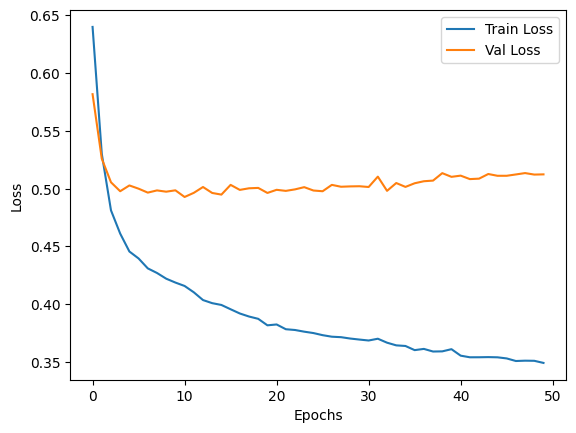

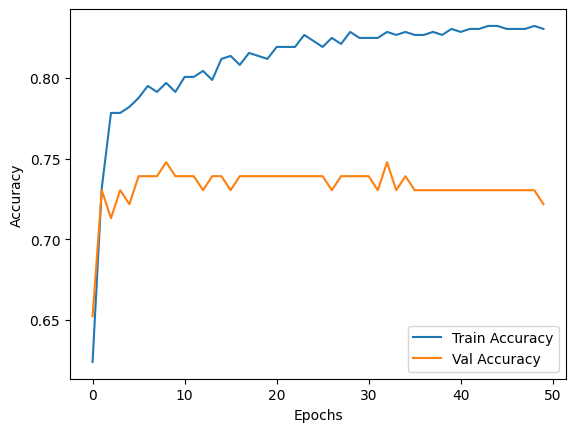

In [30]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.reset_parameters()  # Reset the model

model.to(DEVICE)

# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

history = train(model, trainloader, valloader, optimizer, step_size=20, epochs=50, verbose=True)

plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(history["train_acc"], label="Train Accuracy")
plt.plot(history["val_acc"], label="Val Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## save model

In [31]:
filename = 'diabities_model.pth'

torch.save(model.state_dict(), filename)
print(f"Model saved to {filename}")

Model saved to diabities_model.pth


In [32]:
filename = 'diabities_model.pth'

model.load_state_dict(torch.load(filename, weights_only=True))
model.eval()
print(f"Model loaded from {filename}")

Model loaded from diabities_model.pth


## test

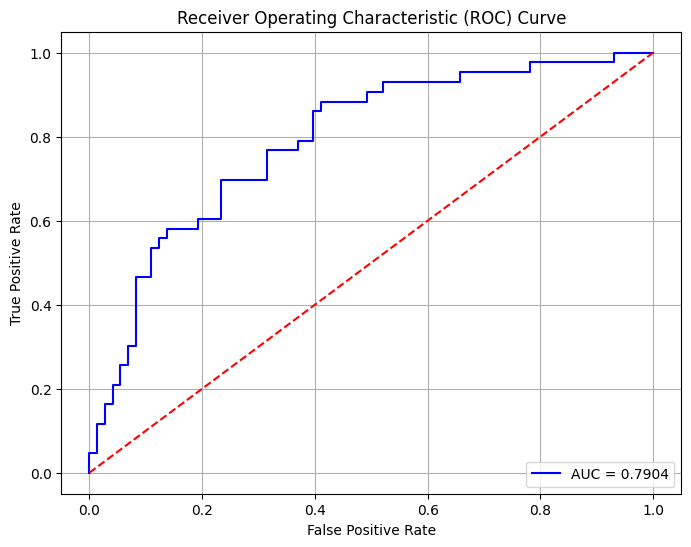

Test Loss: 0.5629, Test Accuracy: 0.7414, AUC: 0.7904
Confusion Matrix:
[[61 12]
 [18 25]]


In [33]:
test_loss, test_acc, auc, cm = test(model, testloader)

# Model 2

In [78]:
class Model_2(nn.Module):
    def __init__(self):
        super(Model_2, self).__init__()
        # Initial layers
        self.fc1 = nn.Linear(8, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)
        self.fc5 = nn.Linear(32, 1)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Forward pass through the layers
        x = F.elu(self.bn1(self.fc1(x)), alpha=1.0)
        x = self.dropout(x)
        x = F.elu(self.bn2(self.fc2(x)), alpha=1.0)

        # New layers forward pass
        x = F.elu(self.bn3(self.fc3(x)), alpha=1.0)  # Apply BatchNorm and activation on fc3
        x = self.fc5(x)  # Final output layer

        return x

    def reset_parameters(self):
        # Reset parameters for all layers
        for layer in self.children():
            if isinstance(layer, nn.Linear):
                init.xavier_uniform_(layer.weight)
                init.zeros_(layer.bias)


In [79]:
model_2 = Model_2()
num_parameters = sum(value.numel() for value in model_2.state_dict().values())
print(f"{num_parameters = }")

num_parameters = 12420


## run

Epoch 1/50 - Learning Rate: 0.01


Epoch 1 Validation: 100%|██████████| 4/4 [00:00<00:00, 534.17it/s]


Epoch 1/50 - Train Loss: 0.6562, Train Acc: 0.6480 - Val Loss: 0.5802, Val Acc: 0.7304
Epoch 2/50 - Learning Rate: 0.01


Epoch 2 Validation: 100%|██████████| 4/4 [00:00<00:00, 245.65it/s]


Epoch 2/50 - Train Loss: 0.4948, Train Acc: 0.7486 - Val Loss: 0.5210, Val Acc: 0.7478
Epoch 3/50 - Learning Rate: 0.01


Epoch 3 Validation: 100%|██████████| 4/4 [00:00<00:00, 418.39it/s]


Epoch 3/50 - Train Loss: 0.4722, Train Acc: 0.7691 - Val Loss: 0.5028, Val Acc: 0.7652
Epoch 4/50 - Learning Rate: 0.01


Epoch 4 Validation: 100%|██████████| 4/4 [00:00<00:00, 377.68it/s]


Epoch 4/50 - Train Loss: 0.4737, Train Acc: 0.7821 - Val Loss: 0.4829, Val Acc: 0.7739
Epoch 5/50 - Learning Rate: 0.01


Epoch 5 Validation: 100%|██████████| 4/4 [00:00<00:00, 75.00it/s]


Epoch 5/50 - Train Loss: 0.4781, Train Acc: 0.7914 - Val Loss: 0.5137, Val Acc: 0.7478
Epoch 6/50 - Learning Rate: 0.01


Epoch 6 Validation: 100%|██████████| 4/4 [00:00<00:00, 566.84it/s]


Epoch 6/50 - Train Loss: 0.4505, Train Acc: 0.7914 - Val Loss: 0.4980, Val Acc: 0.7565
Epoch 7/50 - Learning Rate: 0.01


Epoch 7 Validation: 100%|██████████| 4/4 [00:00<00:00, 214.86it/s]


Epoch 7/50 - Train Loss: 0.4513, Train Acc: 0.7635 - Val Loss: 0.4891, Val Acc: 0.7739
Epoch 8/50 - Learning Rate: 0.01


Epoch 8 Validation: 100%|██████████| 4/4 [00:00<00:00, 409.37it/s]


Epoch 8/50 - Train Loss: 0.4550, Train Acc: 0.7914 - Val Loss: 0.5089, Val Acc: 0.7478
Epoch 9/50 - Learning Rate: 0.01


Epoch 9 Validation: 100%|██████████| 4/4 [00:00<00:00, 237.38it/s]


Epoch 9/50 - Train Loss: 0.4490, Train Acc: 0.7933 - Val Loss: 0.5063, Val Acc: 0.7478
Epoch 10/50 - Learning Rate: 0.01


Epoch 10 Validation: 100%|██████████| 4/4 [00:00<00:00, 122.59it/s]


Epoch 10/50 - Train Loss: 0.4688, Train Acc: 0.7821 - Val Loss: 0.4810, Val Acc: 0.7652
Epoch 11/50 - Learning Rate: 0.01


Epoch 11 Validation: 100%|██████████| 4/4 [00:00<00:00, 219.62it/s]


Epoch 11/50 - Train Loss: 0.4449, Train Acc: 0.7747 - Val Loss: 0.4948, Val Acc: 0.7391
Epoch 12/50 - Learning Rate: 0.01


Epoch 12 Validation: 100%|██████████| 4/4 [00:00<00:00, 82.29it/s]


Epoch 12/50 - Train Loss: 0.4323, Train Acc: 0.7803 - Val Loss: 0.4886, Val Acc: 0.7478
Epoch 13/50 - Learning Rate: 0.01


Epoch 13 Validation: 100%|██████████| 4/4 [00:00<00:00, 635.09it/s]


Epoch 13/50 - Train Loss: 0.4517, Train Acc: 0.7728 - Val Loss: 0.5034, Val Acc: 0.7478
Epoch 14/50 - Learning Rate: 0.01


Epoch 14 Validation: 100%|██████████| 4/4 [00:00<00:00, 138.78it/s]


Epoch 14/50 - Train Loss: 0.4411, Train Acc: 0.7784 - Val Loss: 0.4829, Val Acc: 0.7478
Epoch 15/50 - Learning Rate: 0.01


Epoch 15 Validation: 100%|██████████| 4/4 [00:00<00:00, 133.48it/s]


Epoch 15/50 - Train Loss: 0.4357, Train Acc: 0.7914 - Val Loss: 0.5244, Val Acc: 0.7478
Epoch 16/50 - Learning Rate: 0.01


Epoch 16 Validation: 100%|██████████| 4/4 [00:00<00:00, 123.07it/s]


Epoch 16/50 - Train Loss: 0.4437, Train Acc: 0.7803 - Val Loss: 0.4924, Val Acc: 0.7478
Epoch 17/50 - Learning Rate: 0.01


Epoch 17 Validation: 100%|██████████| 4/4 [00:00<00:00, 102.10it/s]


Epoch 17/50 - Train Loss: 0.4352, Train Acc: 0.7896 - Val Loss: 0.4944, Val Acc: 0.7478
Epoch 18/50 - Learning Rate: 0.01


Epoch 18 Validation: 100%|██████████| 4/4 [00:00<00:00, 323.34it/s]


Epoch 18/50 - Train Loss: 0.4391, Train Acc: 0.7877 - Val Loss: 0.4864, Val Acc: 0.7391
Epoch 19/50 - Learning Rate: 0.01


Epoch 19 Validation: 100%|██████████| 4/4 [00:00<00:00, 97.51it/s]


Epoch 19/50 - Train Loss: 0.4133, Train Acc: 0.8026 - Val Loss: 0.5083, Val Acc: 0.7391
Epoch 20/50 - Learning Rate: 0.01


Epoch 20 Validation: 100%|██████████| 4/4 [00:00<00:00, 441.66it/s]


Epoch 20/50 - Train Loss: 0.4406, Train Acc: 0.7914 - Val Loss: 0.4938, Val Acc: 0.7391
Epoch 21/50 - Learning Rate: 0.005


Epoch 21 Validation: 100%|██████████| 4/4 [00:00<00:00, 309.27it/s]


Epoch 21/50 - Train Loss: 0.4358, Train Acc: 0.7821 - Val Loss: 0.4902, Val Acc: 0.7391
Epoch 22/50 - Learning Rate: 0.005


Epoch 22 Validation: 100%|██████████| 4/4 [00:00<00:00, 463.69it/s]


Epoch 22/50 - Train Loss: 0.4274, Train Acc: 0.7821 - Val Loss: 0.4828, Val Acc: 0.7652
Epoch 23/50 - Learning Rate: 0.005


Epoch 23 Validation: 100%|██████████| 4/4 [00:00<00:00, 295.26it/s]


Epoch 23/50 - Train Loss: 0.4381, Train Acc: 0.7914 - Val Loss: 0.4911, Val Acc: 0.7391
Epoch 24/50 - Learning Rate: 0.005


Epoch 24 Validation: 100%|██████████| 4/4 [00:00<00:00, 584.06it/s]


Epoch 24/50 - Train Loss: 0.4345, Train Acc: 0.7896 - Val Loss: 0.4941, Val Acc: 0.7565
Epoch 25/50 - Learning Rate: 0.005


Epoch 25 Validation: 100%|██████████| 4/4 [00:00<00:00, 312.60it/s]


Epoch 25/50 - Train Loss: 0.4301, Train Acc: 0.7877 - Val Loss: 0.4833, Val Acc: 0.7652
Epoch 26/50 - Learning Rate: 0.005


Epoch 26 Validation: 100%|██████████| 4/4 [00:00<00:00, 289.08it/s]


Epoch 26/50 - Train Loss: 0.4472, Train Acc: 0.7803 - Val Loss: 0.4936, Val Acc: 0.7652
Epoch 27/50 - Learning Rate: 0.005


Epoch 27 Validation: 100%|██████████| 4/4 [00:00<00:00, 193.58it/s]


Epoch 27/50 - Train Loss: 0.4132, Train Acc: 0.7952 - Val Loss: 0.4946, Val Acc: 0.7391
Epoch 28/50 - Learning Rate: 0.005


Epoch 28 Validation: 100%|██████████| 4/4 [00:00<00:00, 88.14it/s]


Epoch 28/50 - Train Loss: 0.4246, Train Acc: 0.8007 - Val Loss: 0.4984, Val Acc: 0.7391
Epoch 29/50 - Learning Rate: 0.005


Epoch 29 Validation: 100%|██████████| 4/4 [00:00<00:00, 374.73it/s]


Epoch 29/50 - Train Loss: 0.4194, Train Acc: 0.7821 - Val Loss: 0.4892, Val Acc: 0.7652
Epoch 30/50 - Learning Rate: 0.005


Epoch 30 Validation: 100%|██████████| 4/4 [00:00<00:00, 321.11it/s]


Epoch 30/50 - Train Loss: 0.4102, Train Acc: 0.8063 - Val Loss: 0.4849, Val Acc: 0.7478
Epoch 31/50 - Learning Rate: 0.005


Epoch 31 Validation: 100%|██████████| 4/4 [00:00<00:00, 587.27it/s]


Epoch 31/50 - Train Loss: 0.4058, Train Acc: 0.8101 - Val Loss: 0.4900, Val Acc: 0.7565
Epoch 32/50 - Learning Rate: 0.005


Epoch 32 Validation: 100%|██████████| 4/4 [00:00<00:00, 214.63it/s]


Epoch 32/50 - Train Loss: 0.4220, Train Acc: 0.7989 - Val Loss: 0.5029, Val Acc: 0.7391
Epoch 33/50 - Learning Rate: 0.005


Epoch 33 Validation: 100%|██████████| 4/4 [00:00<00:00, 523.03it/s]


Epoch 33/50 - Train Loss: 0.4335, Train Acc: 0.7914 - Val Loss: 0.5044, Val Acc: 0.7391
Epoch 34/50 - Learning Rate: 0.005


Epoch 34 Validation: 100%|██████████| 4/4 [00:00<00:00, 224.59it/s]


Epoch 34/50 - Train Loss: 0.4222, Train Acc: 0.7877 - Val Loss: 0.4937, Val Acc: 0.7478
Epoch 35/50 - Learning Rate: 0.005


Epoch 35 Validation: 100%|██████████| 4/4 [00:00<00:00, 134.17it/s]


Epoch 35/50 - Train Loss: 0.4095, Train Acc: 0.8063 - Val Loss: 0.4863, Val Acc: 0.7565
Epoch 36/50 - Learning Rate: 0.005


Epoch 36 Validation: 100%|██████████| 4/4 [00:00<00:00, 190.41it/s]


Epoch 36/50 - Train Loss: 0.4150, Train Acc: 0.7877 - Val Loss: 0.4865, Val Acc: 0.7652
Epoch 37/50 - Learning Rate: 0.005


Epoch 37 Validation: 100%|██████████| 4/4 [00:00<00:00, 464.28it/s]


Epoch 37/50 - Train Loss: 0.3988, Train Acc: 0.8101 - Val Loss: 0.4970, Val Acc: 0.7565
Epoch 38/50 - Learning Rate: 0.005


Epoch 38 Validation: 100%|██████████| 4/4 [00:00<00:00, 400.54it/s]


Epoch 38/50 - Train Loss: 0.4229, Train Acc: 0.7933 - Val Loss: 0.4912, Val Acc: 0.7478
Epoch 39/50 - Learning Rate: 0.005


Epoch 39 Validation: 100%|██████████| 4/4 [00:00<00:00, 363.38it/s]


Epoch 39/50 - Train Loss: 0.4005, Train Acc: 0.8007 - Val Loss: 0.5011, Val Acc: 0.7478
Epoch 40/50 - Learning Rate: 0.005


Epoch 40 Validation: 100%|██████████| 4/4 [00:00<00:00, 208.72it/s]


Epoch 40/50 - Train Loss: 0.4229, Train Acc: 0.8045 - Val Loss: 0.4844, Val Acc: 0.7478
Epoch 41/50 - Learning Rate: 0.0025


Epoch 41 Validation: 100%|██████████| 4/4 [00:00<00:00, 452.53it/s]


Epoch 41/50 - Train Loss: 0.4091, Train Acc: 0.8101 - Val Loss: 0.4874, Val Acc: 0.7478
Epoch 42/50 - Learning Rate: 0.0025


Epoch 42 Validation: 100%|██████████| 4/4 [00:00<00:00, 462.46it/s]


Epoch 42/50 - Train Loss: 0.3976, Train Acc: 0.8175 - Val Loss: 0.4889, Val Acc: 0.7478
Epoch 43/50 - Learning Rate: 0.0025


Epoch 43 Validation: 100%|██████████| 4/4 [00:00<00:00, 244.70it/s]


Epoch 43/50 - Train Loss: 0.4104, Train Acc: 0.8045 - Val Loss: 0.4941, Val Acc: 0.7565
Epoch 44/50 - Learning Rate: 0.0025


Epoch 44 Validation: 100%|██████████| 4/4 [00:00<00:00, 230.51it/s]


Epoch 44/50 - Train Loss: 0.4178, Train Acc: 0.7989 - Val Loss: 0.4908, Val Acc: 0.7565
Epoch 45/50 - Learning Rate: 0.0025


Epoch 45 Validation: 100%|██████████| 4/4 [00:00<00:00, 216.18it/s]


Epoch 45/50 - Train Loss: 0.4257, Train Acc: 0.7933 - Val Loss: 0.4845, Val Acc: 0.7478
Epoch 46/50 - Learning Rate: 0.0025


Epoch 46 Validation: 100%|██████████| 4/4 [00:00<00:00, 160.55it/s]


Epoch 46/50 - Train Loss: 0.4030, Train Acc: 0.8082 - Val Loss: 0.4858, Val Acc: 0.7565
Epoch 47/50 - Learning Rate: 0.0025


Epoch 47 Validation: 100%|██████████| 4/4 [00:00<00:00, 395.00it/s]


Epoch 47/50 - Train Loss: 0.4133, Train Acc: 0.7933 - Val Loss: 0.4924, Val Acc: 0.7478
Epoch 48/50 - Learning Rate: 0.0025


Epoch 48 Validation: 100%|██████████| 4/4 [00:00<00:00, 166.79it/s]


Epoch 48/50 - Train Loss: 0.4013, Train Acc: 0.8045 - Val Loss: 0.5008, Val Acc: 0.7478
Epoch 49/50 - Learning Rate: 0.0025


Epoch 49 Validation: 100%|██████████| 4/4 [00:00<00:00, 526.06it/s]


Epoch 49/50 - Train Loss: 0.4083, Train Acc: 0.8063 - Val Loss: 0.4933, Val Acc: 0.7478
Epoch 50/50 - Learning Rate: 0.0025


Epoch 50 Validation: 100%|██████████| 4/4 [00:00<00:00, 289.29it/s]


Epoch 50/50 - Train Loss: 0.4025, Train Acc: 0.8007 - Val Loss: 0.4913, Val Acc: 0.7478


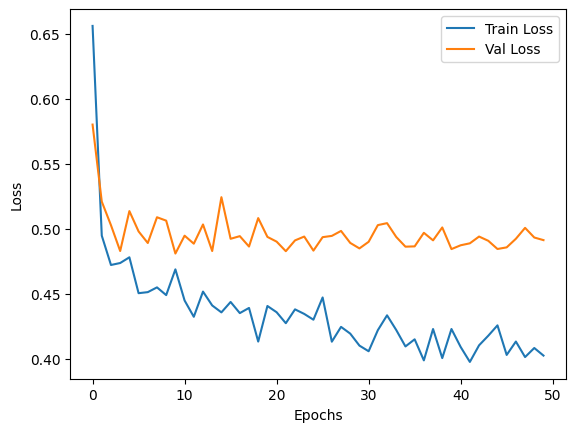

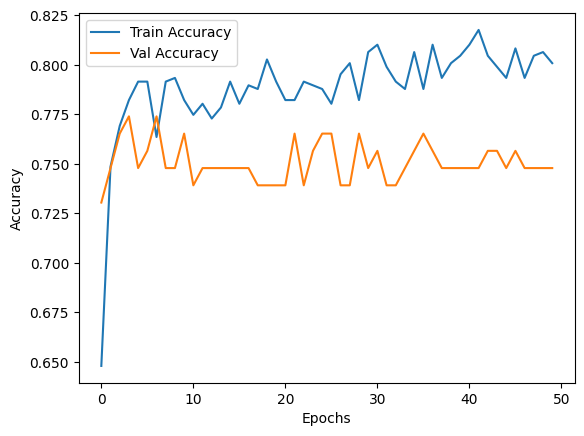

In [80]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_2.reset_parameters()  # Reset the model

model_2.to(DEVICE)

# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-5)

history = train(model_2, trainloader, valloader, optimizer, step_size=20, epochs=50, verbose=True)

plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(history["train_acc"], label="Train Accuracy")
plt.plot(history["val_acc"], label="Val Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## save model

In [81]:
filename = 'diabities_Model_2.pth'

torch.save(model_2.state_dict(), filename)
print(f"Model saved to {filename}")

Model saved to diabities_Model_2.pth


In [82]:
model_2 = Model_2()
model_2.load_state_dict(torch.load(filename, weights_only=True))
model_2.eval()
print(f"Model loaded from {filename}")

Model loaded from diabities_Model_2.pth


## test

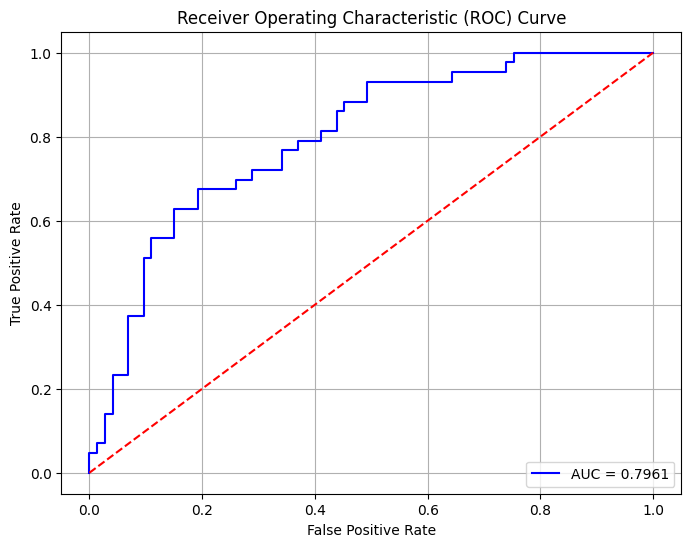

Test Loss: 0.5374, Test Accuracy: 0.7672, AUC: 0.7961
Confusion Matrix:
[[62 11]
 [16 27]]


In [83]:
test_loss, test_acc, auc, cm = test(model_2, testloader)